In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_massfunc import CSMF, SHMR, scatter_stat, mass_rank
from jsm_datareduc import prep_data
from galhalo import lgMs_D22_dex, dex_sampler, lgMs_D22_det
import galhalo
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
conv = 1/np.log10(np.exp(1))

dist = conv*np.log10(np.random.lognormal(mean=1, sigma=1 ,size=100000))

ave = np.mean(dist)
std = np.std(dist)

print(ave, std)

0.9952278413651741 1.0016491508688874


In [4]:
conv

2.302585092994046

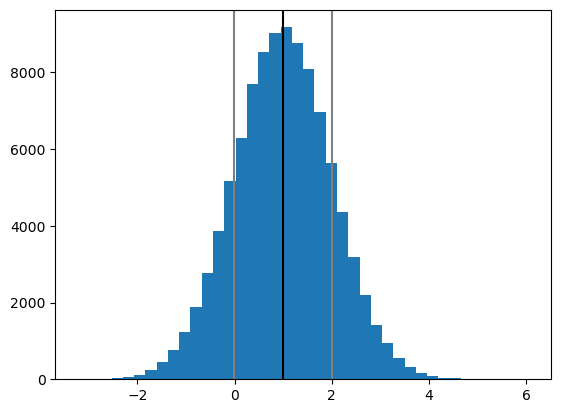

In [5]:
plt.hist(dist, bins=40)
plt.axvline(ave, color="black")
plt.axvline(ave+std, color="grey")
plt.axvline(ave-std, color="grey")
plt.show()


In [6]:
def avemass(mu, sigma):
    exp = mu + (sigma**2)/2
    return np.exp(exp)

def varmass(mu, sigma):
    exp = 2*sigma**2 + 2*mu
    return np.exp(exp)

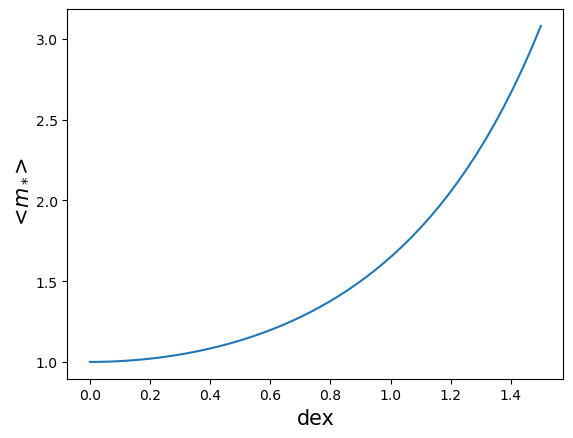

In [7]:
sigma = np.linspace(0,1.5, 50)

plt.plot(sigma, avemass(0, sigma))
plt.xlabel("dex", fontsize=15)
plt.ylabel(" <$m_*$>", fontsize=15)
#plt.savefig("simple_illust.pdf")
plt.show()


----------

$\log_{10} (M_{*}) = \log_{10} (\epsilon M_{1})+ \alpha \log_{10} (M_{peak}) - \alpha \log_{10}(M_1)$

$ M_{*} = \epsilon M_{1} \left( \frac{M_{peak}}{M_1} \right)^{\alpha}$

$ M_{*} = \left( \epsilon M_{1}^{1-\alpha} \right) \left( M_{peak} \right)^{\alpha} $

$\log_{10} (M_{*}) = \alpha \log_{10} (M_{peak}) + \log_{10}\left( \epsilon M_{1}^{1-\alpha} \right)$

$y = mx + b$, where $a$ is the slope, and $b$ the intercept, is a function of the slope and the normalization 

In [8]:
Mh = prep_data(("../../data/12_4_0/numpy/acc_surv_mass.npy"), convert=False, includenan=False)
Ms = prep_data(("../../data/12_4_0/numpy/acc_surv_mass.npy"), includenan=False)

halo_mass = Mh[0]
stellar_mass = Ms[0]

In [9]:
samp1 = dex_sampler(stellar_mass, 0.5, 10)[0,:]

samp2 = dex_sampler(stellar_mass, 1, 10)[0,:]

samp3 = dex_sampler(stellar_mass, 1.5, 10)[0,:]

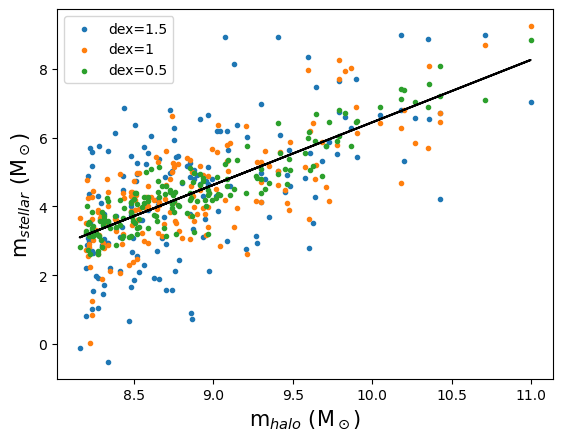

In [10]:
plt.scatter(halo_mass, samp3, marker=".", label="dex=1.5")
plt.scatter(halo_mass, samp2, marker=".", label="dex=1")
plt.scatter(halo_mass, samp1, marker=".", label="dex=0.5")
plt.plot(halo_mass, stellar_mass, color="black")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend()
plt.show()

In [44]:
np.log(10)

2.302585092994046

In [49]:
def lgMs_D22_test(lgMv, dex):
    """    
    returns the stellar mass [M_sun] plus a random sample of a lognormal distribution defined by dex
    """
    log_e = -1.5
    a = 1.82
    lgMs = log_e + 12.5 + a*lgMv - a*12.5

    norm = (dex**2)/4.605

    return lgMs - norm

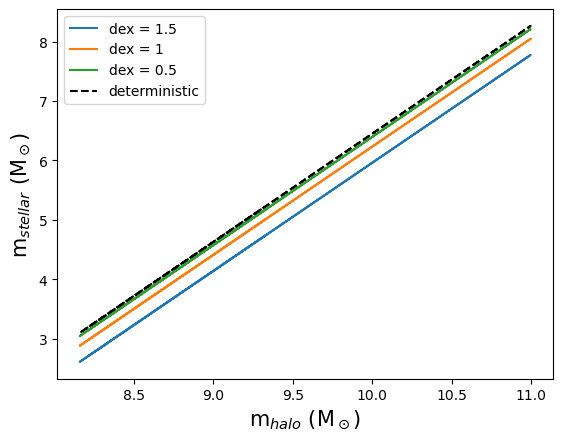

In [51]:
plt.plot(halo_mass, lgMs_D22_test(halo_mass,1.5), label="dex = 1.5")
plt.plot(halo_mass, lgMs_D22_test(halo_mass,1), label="dex = 1")
plt.plot(halo_mass, lgMs_D22_test(halo_mass,0.5) , label="dex = 0.5")

plt.plot(halo_mass, stellar_mass, color="black", label="deterministic", ls="--")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend()
plt.savefig("../figures/scaling_SHMR.pdf")
plt.show()

In [52]:
def lgMs_D22_test(lgMv, dex, N_samples, norm=False):
    """    
    returns the stellar mass [M_sun] plus a random sample of a lognormal distribution defined by dex
    """
    log_e = -1.5
    a = 1.82
    lgMs = log_e + 12.5 + a*lgMv - a*12.5

    sample = np.random.lognormal(lgMs, dex, size=(N_samples, lgMs.shape[0]))
    lgMs_mat = np.log10(sample)/np.log10(np.exp(1))

    if norm==True:
        norm = (dex**2)/4.605
        return lgMs_mat - norm

    else:
        return lgMs_mat

$ M_{*} = \epsilon M_{1} \left( \frac{M_{peak}}{M_1} \right)^{\alpha}$


In [58]:
i = 124
print(stellar_mass[i])

_, bins = np.histogram(np.nan, bins=50, range=[-3, 10], normed=True)


5.505109796264975


/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_36690/739267491.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  _, bins = np.histogram(np.nan, bins=50, range=[-3, 10], normed=True)


In [54]:
wow1 = lgMs_D22_test(halo_mass,1.5,1000)
dist1 = wow1[:,i]
ave1 = np.mean(dist1)
std1 = ave1 + 1.5

wow2 = lgMs_D22_test(halo_mass,1,1000)
dist2 = wow2[:,i]
ave2 = np.mean(dist2)
std2 = ave2 + 1

wow3 = lgMs_D22_test(halo_mass,0.5,1000)
dist3 = wow3[:,i]
ave3 = np.mean(dist3)
std3 = ave3 + 0.5

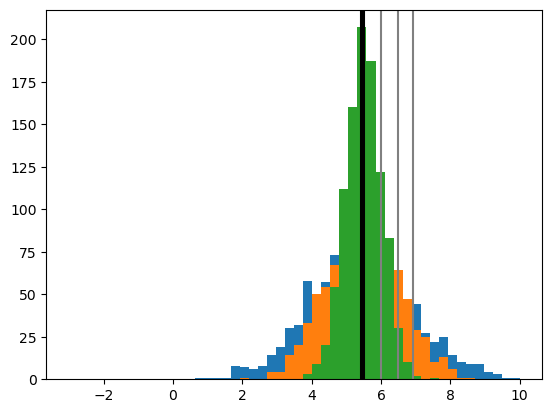

5.424997733132817 5.482252418949151 5.497128293362795
266071.1171769301 303565.50431669765 314143.6557237236


In [55]:
plt.hist(dist1, bins=bins)
plt.axvline(ave1, color="black")
plt.axvline(std1, color="grey")
plt.hist(dist2, bins=bins)
plt.axvline(ave2, color="black")
plt.axvline(std2, color="grey")
plt.hist(dist3, bins=bins)
plt.axvline(ave3, color="black")
plt.axvline(std3, color="grey")
plt.show()

print(ave1, ave2, ave3)
print(10**ave1, 10**ave2, 10**ave3)


In [56]:
wow1 = lgMs_D22_test(halo_mass,1.5,1000, norm=True)
dist1 = wow1[:,i]
ave1 = np.mean(dist1)
std1 = ave1 + 1.5

wow2 = lgMs_D22_test(halo_mass,1,1000, norm=True)
dist2 = wow2[:,i]
ave2 = np.mean(dist2)
std2 = ave2 + 1

wow3 = lgMs_D22_test(halo_mass,0.5,1000, norm=True)
dist3 = wow3[:,i]
ave3 = np.mean(dist3)
std3 = ave3 + 0.5

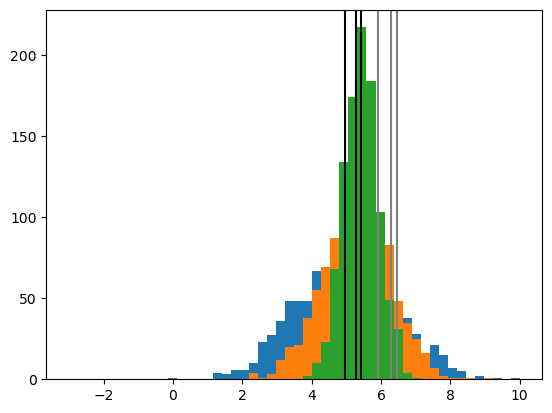

4.963403582362899 5.289433534562166 5.42176847256119
91918.63837517233 194730.30073540713 264100.04339144076


In [57]:
plt.hist(dist1, bins=bins)
plt.axvline(ave1, color="black")
plt.axvline(std1, color="grey")
plt.hist(dist2, bins=bins)
plt.axvline(ave2, color="black")
plt.axvline(std2, color="grey")
plt.hist(dist3, bins=bins)
plt.axvline(ave3, color="black")
plt.axvline(std3, color="grey")
plt.show()

print(ave1, ave2, ave3)
print(10**ave1, 10**ave2, 10**ave3)
